# Problem Statement: Time analysis on table1(FBI Crime Data)

In [45]:
#Import packages

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing

from pandas import datetime
from pandas import DataFrame
from matplotlib import pyplot
from fbprophet import Prophet
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [85]:
#variables

table1 = './data/table_1_crime_in_the_united_states_by_volume_and_rate_per_100000_inhabitants_1994-2013.xls'
table2 = './data//home/vishnu/Desktop/Assignment_vishnusdev/data/table_12_crime_trends_by_population_group_2012-2013.xls'
row_strt = 4
row_end = 20
col_strt = 0
col_end = 20
rcParams['figure.figsize'] = 15, 6

In [47]:
#Define functions
#regex for filtering year format
def regex_filter(val):
    if val:
        yr = len(str(val))
        if yr==4:
            return val
        else:
            return int(str(val[0:yr-1]))
    else:
        return 0
#show a graphical representation for the top and bottom 5 of data
def plot_frequency(x,data):
    plt.subplot(2, 1, 1)
    sns.countplot(x=x, data=data,
                              order=data[x].value_counts().iloc[:5].index)
    plt.subplot(2, 1, 2)
    sns.countplot(x=x, data=data,
                              order=data[x].value_counts().iloc[-5:].index)        
    plt.show()

def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
#Simple Linear regression  
def plot_regression_line(x, y, b, name, log_scale): 
    fig = plt.figure(figsize=(10,5))
    plt.title(name + ', log_scale = ' + str(log_scale))
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 40) 
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    plt.plot(x, y_pred, color = "g") 
  
    # putting labels 
    plt.xlabel('Year')  
    plt.ylabel('Number of Crimes') 
  
    # function to show plot 
    plt.show() 
def fit_regression(X, log_scale = False, forecast = False):
    y = np.array(X)
    y = y.astype(float).reshape(y.size,1)
    y_log = np.log(y)
    x = np.asarray(X.index)
    x = x.astype(float).reshape(x.size,1)
    x_log = np.log(y)
    b = estimate_coef(x, y)
    if forecast:
        list_years = list(range(2015, 2030))
        preds = [prediction(l, b) for l in list_years]
        df = pd.DataFrame(preds)
        df.astype(int)
        df.columns = [str(X.columns[0]), 'Year']
#         df = df.set_index('Year')
        ax = df.plot.bar(x='Year', y=str(X.columns[0]), rot=0, title =str(X.columns[0])+' :Forecast', legend=False)
    else:
        b_log = estimate_coef(x_log, y_log) 
        if log_scale:
            plot_regression_line(x_log, y_log, b_log, X.columns[0], log_scale)
        else:
            plot_regression_line(x, y, b, X.columns[0], log_scale)
def prediction(x, b):
    x = np.asarray(x)
    x = x.astype(float).reshape(x.size,1)
    y_pred = b[0] + b[1]*x
    return(y_pred[0].tolist()[0], x[0].tolist()[0])

### Read data and Pre-processing

In [48]:
data = pd.read_excel(table1,skiprows = 3, encoding='UTF-8')
req_data = data.iloc[row_strt:row_end, col_strt:col_end].reset_index()
all_cols = [r.replace('\n', ' ')for r in req_data.columns]
req_data.columns = all_cols
#regex for formatting year
req_data['Year'] = req_data['Year'].apply(regex_filter)
year_population = req_data[['Year', 'Population1']]
crime_data = req_data
#check to see if any value is NaN in the dataframe
print('are there any null values?',crime_data.isnull().values.any())

are there any null values? False


In [49]:
x = year_population.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
#Scaling 
x_scaled = min_max_scaler.fit_transform(x)
dfw= pd.DataFrame(x_scaled)
# plt.plot(dfw)

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Year vs Population growth

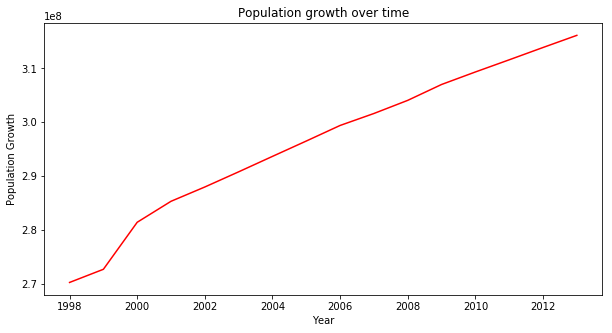

In [50]:
year = np.array(req_data['Year'])
normalized_year = preprocessing.normalize([year])
Population =np.array(req_data['Population1'])
normalized_Population = preprocessing.normalize([Population])

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('Population growth over time')
plt.plot(year, Population,color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Population Growth')
plt.show()

### Analyze over various crime scenarios

In [51]:
req_data = req_data.set_index('Year')
Violent_crimes=req_data[['Violent crime']]
Murder_and_manslaughter=req_data[['Murder and nonnegligent  manslaughter']]
Robbery = req_data[['Robbery']]
Aggravated_assault = req_data[['Aggravated  assault']]
Property_crime = req_data[['Property  crime']]
Burglary = req_data[['Burglary']]
Larceny_theft = req_data[['Larceny- theft']]
Motor_vehicle_theft = req_data[['Motor  vehicle  theft']]

In [52]:
# Violent_crimes.head()
# #Crime Plot
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(111)
# ax.set_title('Crime vs Year')
# plt.plot(Violent_crimes,color='blue')
# ax.set_xlabel('Year')
# ax.set_ylabel('Number of Crmes')
# plt.show()

In [53]:
req_data

,index,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate,Rape (legacy definition)2,Rape (legacy definition)2 rate,Robbery,Robbery rate,Aggravated assault,Aggravated assault rate,Property crime,Property crime rate,Burglary,Burglary rate,Larceny- theft,Larceny- theft rate,Motor vehicle theft,Motor vehicle theft rate
Year,,,,,,,,,,,,,,,,,,,,
1998,4,270248003.0,1533887,567.6,16974,6.3,93144,34.5,447186,165.5,976583,361.4,10951827,4052.5,2332735,863.2,7376311,2729.5,1242781,459.9
1999,5,272690813.0,1426044,523,15522,5.7,89411,32.8,409371,150.1,911740,334.3,10208334,3743.6,2100739,770.4,6955520,2550.7,1152075,422.5
2000,6,281421906.0,1425486,506.5,15586,5.5,90178,32,408016,145,911706,324,10182584,3618.3,2050992,728.8,6971590,2477.3,1160002,412.2
2001,7,285317559.0,1439480,504.5,16037,5.6,90863,31.8,423557,148.5,909023,318.6,10437189,3658.1,2116531,741.8,7092267,2485.7,1228391,430.5
2002,8,287973924.0,1423677,494.4,16229,5.6,95235,33.1,420806,146.1,891407,309.5,10455277,3630.6,2151252,747,7057379,2450.7,1246646,432.9
2003,9,290788976.0,1383676,475.8,16528,5.7,93883,32.3,414235,142.5,859030,295.4,10442862,3591.2,2154834,741,7026802,2416.5,1261226,433.7
2004,10,293656842.0,1360088,463.2,16148,5.5,95089,32.4,401470,136.7,847381,288.6,10319386,3514.1,2144446,730.3,6937089,2362.3,1237851,421.5
2005,11,296507061.0,1390745,469,16740,5.6,94347,31.8,417438,140.8,862220,290.8,10174754,3431.5,2155448,726.9,6783447,2287.8,1235859,416.8
2006,12,299398484.0,1435123,479.3,17309,5.8,94472,31.6,449246,150,874096,292,10019601,3346.6,2194993,733.1,6626363,2213.2,1198245,400.2


In [54]:
# all_cols

In [55]:
crime_data[all_cols] = crime_data[all_cols].apply(pd.to_numeric, errors ='ignore')

In [56]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 21 columns):
index                                            16 non-null int64
Year                                             16 non-null int64
Population1                                      16 non-null float64
Violent crime                                    16 non-null int64
Violent  crime  rate                             16 non-null float64
Murder and nonnegligent  manslaughter            16 non-null int64
Murder and  nonnegligent  manslaughter  rate     16 non-null float64
Rape (legacy definition)2                        16 non-null int64
Rape (legacy definition)2 rate                   16 non-null float64
Robbery                                          16 non-null int64
Robbery  rate                                    16 non-null float64
Aggravated  assault                              16 non-null int64
Aggravated  assault rate                         16 non-null float64
Property  crim

In [57]:
print(req_data.describe())

           index   Population1
count  16.000000  1.600000e+01
mean   11.500000  2.963507e+08
std     4.760952  1.414929e+07
min     4.000000  2.702480e+08
25%     7.750000  2.873098e+08
50%    11.500000  2.979528e+08
75%    15.250000  3.075875e+08
max    19.000000  3.161288e+08


In [58]:
# gg = req_data.T

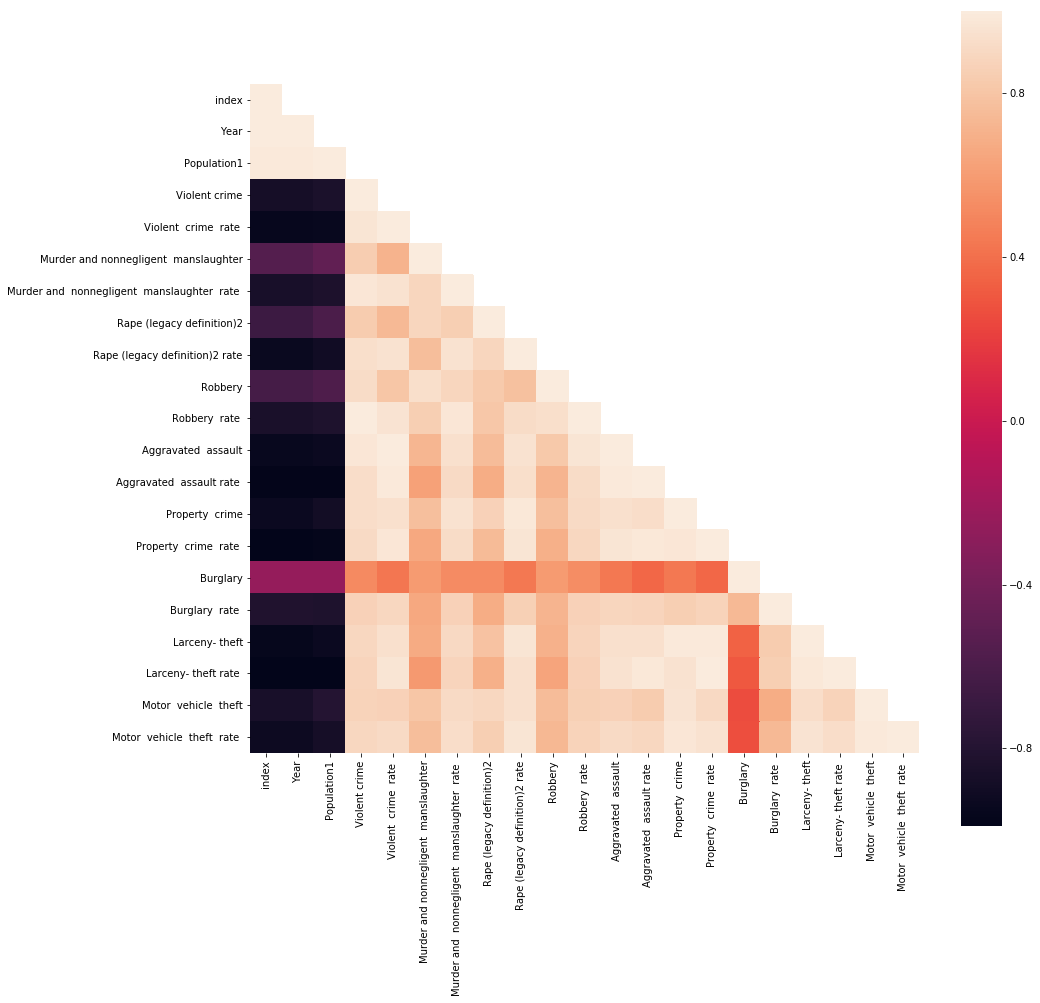

In [59]:
corr = crime_data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
sns.heatmap(corr, mask=mask, ax=ax, square=True)

In [60]:
# all_cols

In [61]:
qq = crime_data[[all_cols[5], all_cols[7], all_cols[9], all_cols[11], all_cols[13], all_cols[15], all_cols[17], all_cols[19]]]

In [62]:
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(111)
# ax.set_title('Crime vs Year')
# plt.plot(qq,color='blue')
# ax.set_xlabel('Year')
# ax.set_ylabel('Number of Crmes')
# plt.show()

In [63]:
crime_data = crime_data.astype(int)
crime_data['Year'].min(), crime_data['Year'].max()

(1998, 2013)

In [64]:
Violent_crimes = Violent_crimes.astype(int)

In [65]:
Violent_crimes

,Violent crime
Year,
1998,1533887
1999,1426044
2000,1425486
2001,1439480
2002,1423677
2003,1383676
2004,1360088
2005,1390745
2006,1435123


In [66]:
lag_acf = acf(Violent_crimes, nlags=20)
lag_pacf = pacf(Violent_crimes, nlags=10, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

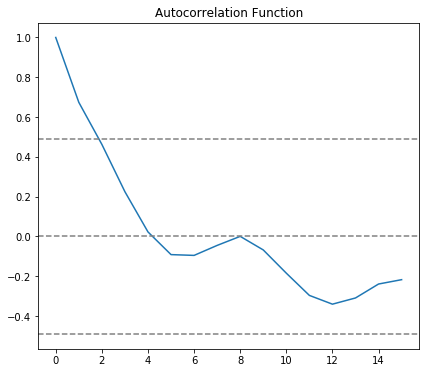

In [67]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Violent_crimes)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Violent_crimes)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

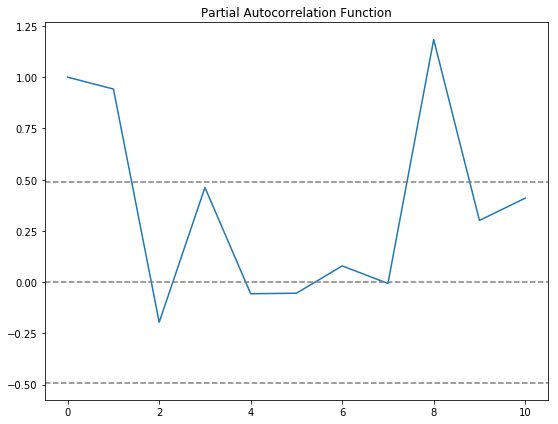

In [68]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Violent_crimes)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Violent_crimes)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [69]:

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/vishnu/.virtualenvs/dl/lib/python3.6/

                             ARIMA Model Results                              
Dep. Variable:        D.Violent crime   No. Observations:                   15
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -178.027
Method:                       css-mle   S.D. of innovations          33048.459
Date:                Sun, 09 Dec 2018   AIC                            370.053
Time:                        23:43:30   BIC                            375.009
Sample:                             1   HQIC                           370.000
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.002e+04   1.38e+04     -2.173      0.058   -5.71e+04   -2946.823
ar.L1.D.Violent crime     0.7330      0.393      1.863      0.095      -0.038       1.504
ar.L2.D.

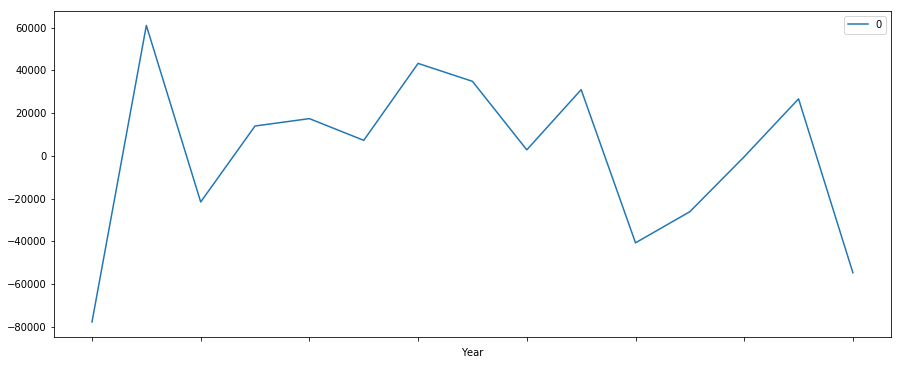

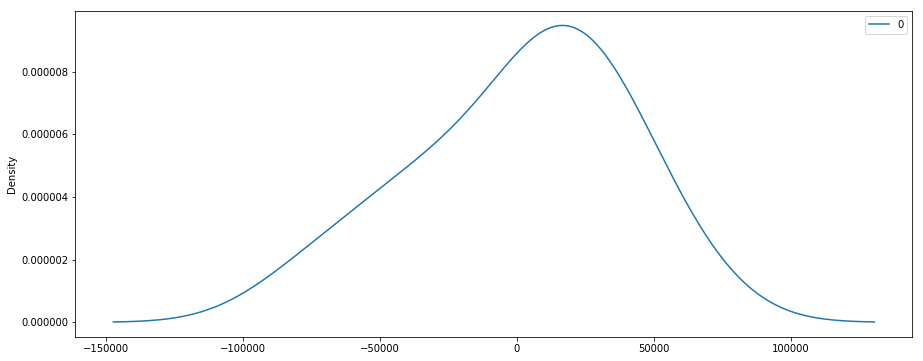

                  0
count     15.000000
mean    1106.523104
std    38633.546436
min   -77825.185528
25%   -23899.277611
50%     7236.416789
75%    28825.627676
max    61035.428013


In [70]:


 
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(Violent_crimes, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [71]:
Violent_crimes.index

Index([  1998,   1999,   2000,   2001,   2002, '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011',   2012, '2013'],
      dtype='object', name='Year')

In [72]:
model = ARIMA(Violent_crimes, order=(2, 1, 0))  

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


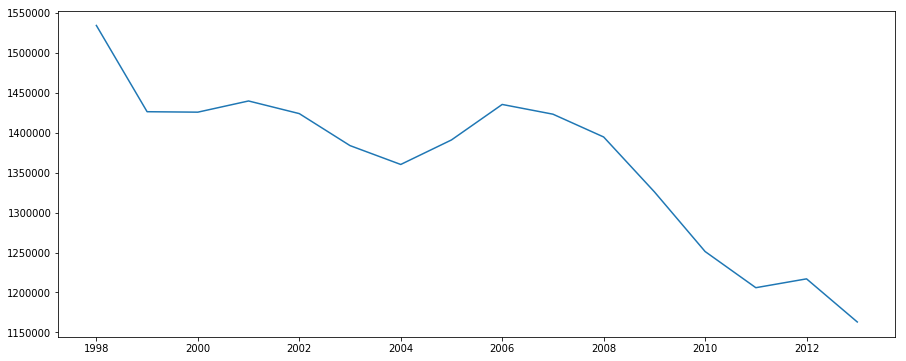

In [73]:
results_AR = model.fit(disp=-1)  
plt.plot(Violent_crimes)
# plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-Violent_crimes)**2))

In [74]:
 predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Year
1999   -27317.522227
2000   -58698.572759
2001    32192.258171
2002   -16970.906065
2003   -42701.809686
dtype: float64


In [75]:
plot_dict = {'Violent_crimes':'yellow', 'Murder_and_manslaughter':'blue', 'Robbery':'green', 'Aggravated_assault':'orange', 
            'Property_crime':'brown', 'Burglary':'black', 'Larceny_theft':'red', 'Motor_vehicle_theft':'yellow'}

### Visualizing Data

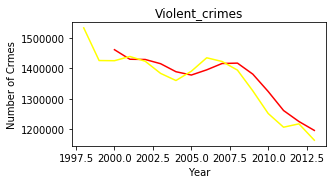

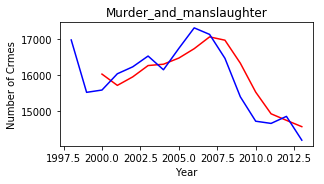

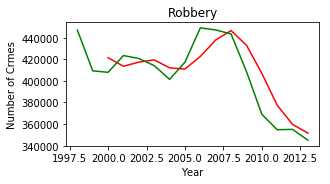

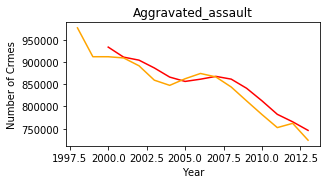

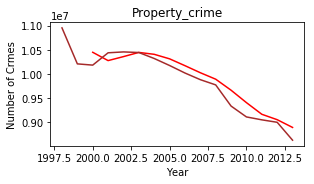

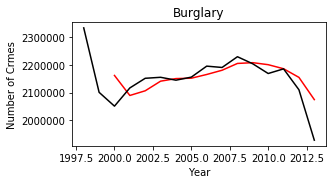

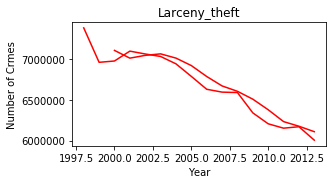

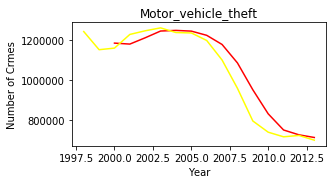

In [76]:
for k, v in plot_dict.items():
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(221)
    ax.set_title(str(k))
    moving_avg = eval(k).rolling(3).mean()
#     mte_exp_wighted_avg = pd.DataFrame.ewma(eval(k), halflife=3)
    plt.plot(moving_avg, color = 'red')
    plt.plot(eval(k),color=str(v))
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Crmes')
    plt.show()

### Running a simple linear regression over crime scenes

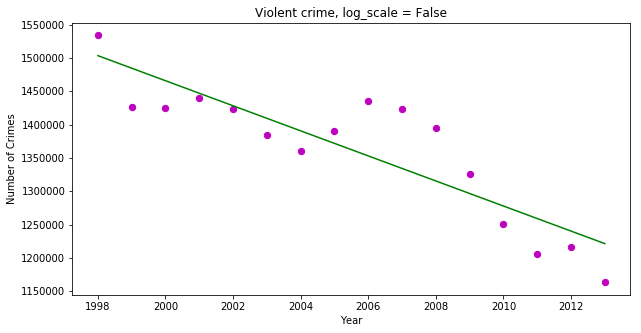

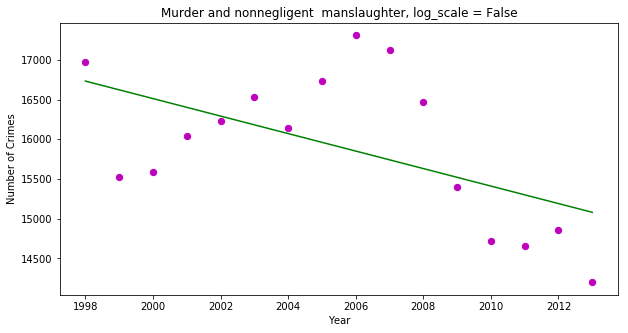

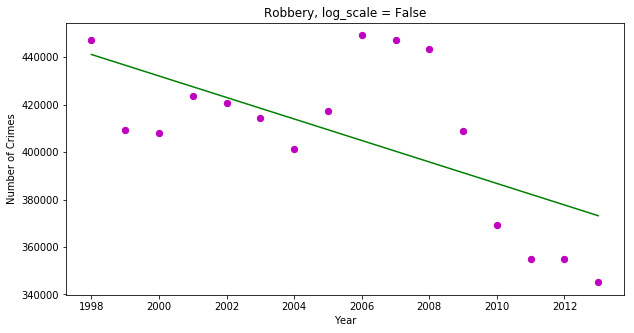

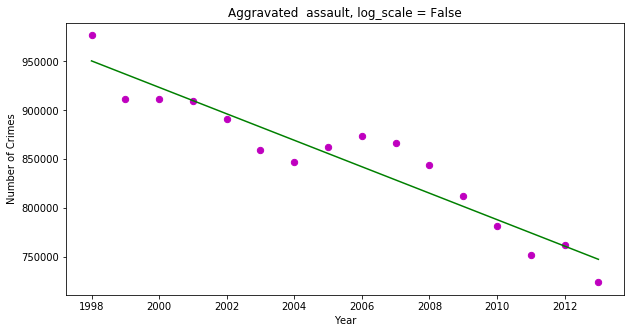

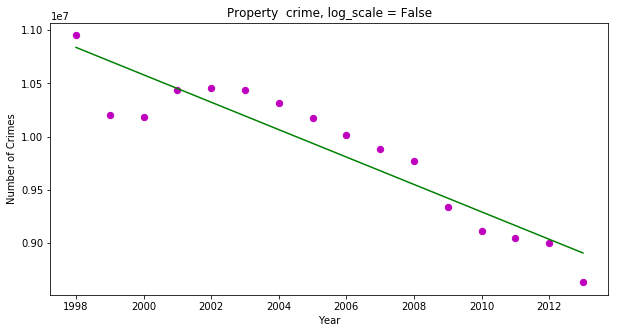

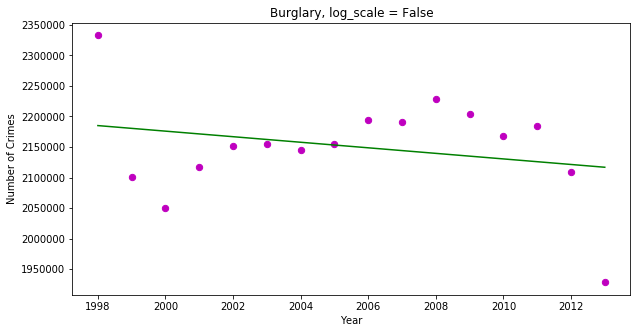

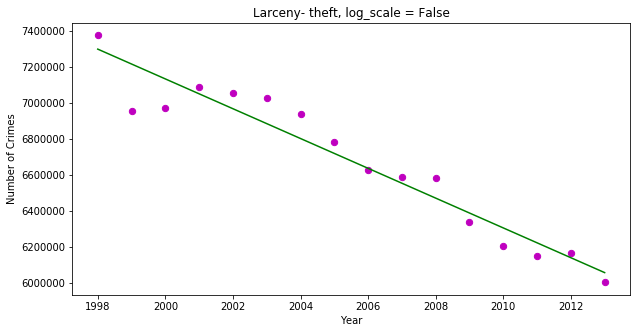

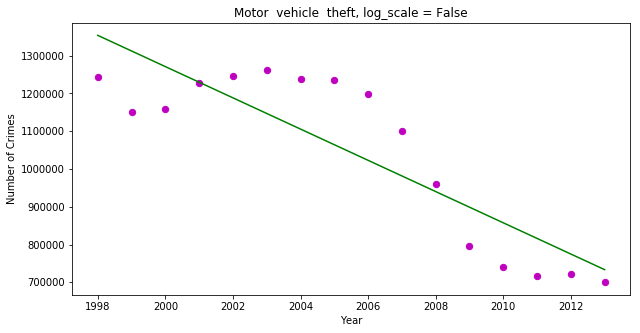

In [77]:
for k, v in plot_dict.items():
    fit_regression(eval(k), log_scale = False, forecast=False)

### Forecasting: Predict the next years based on the past years

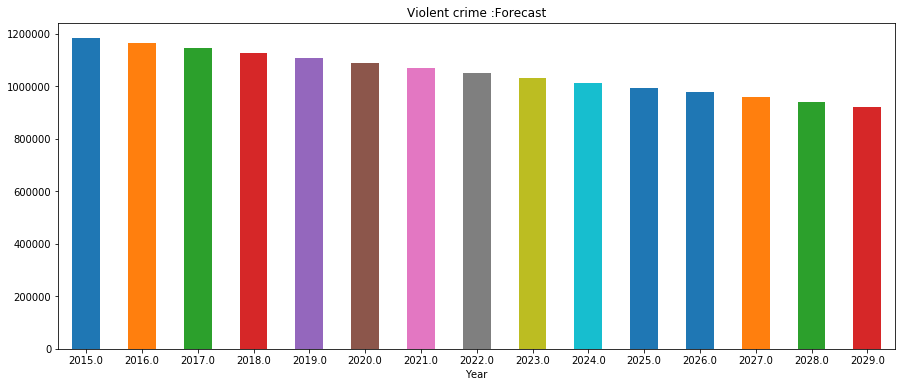

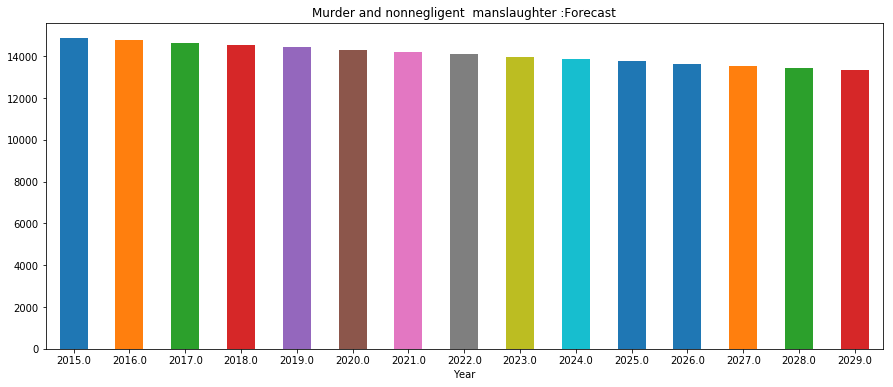

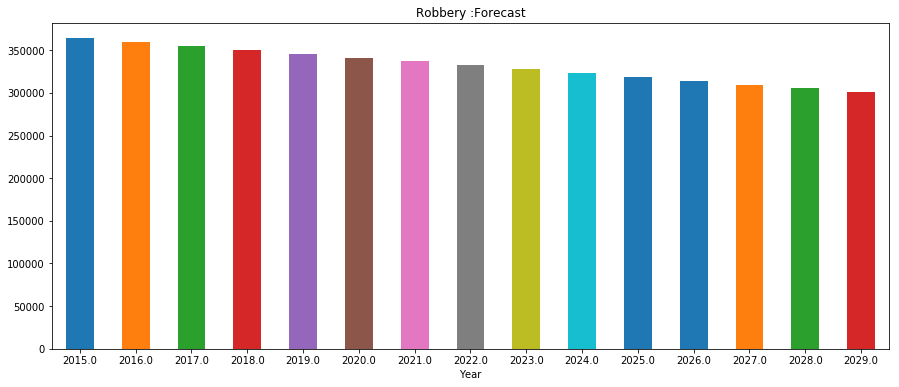

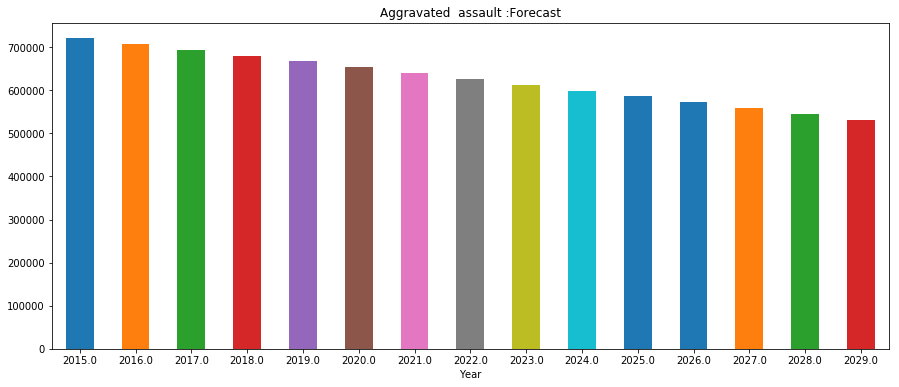

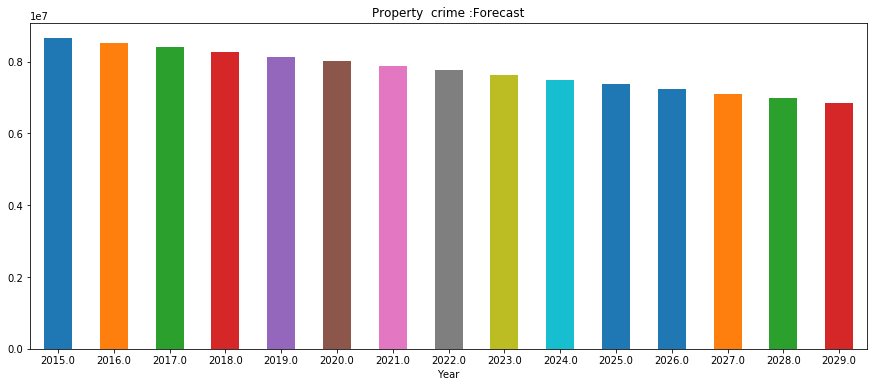

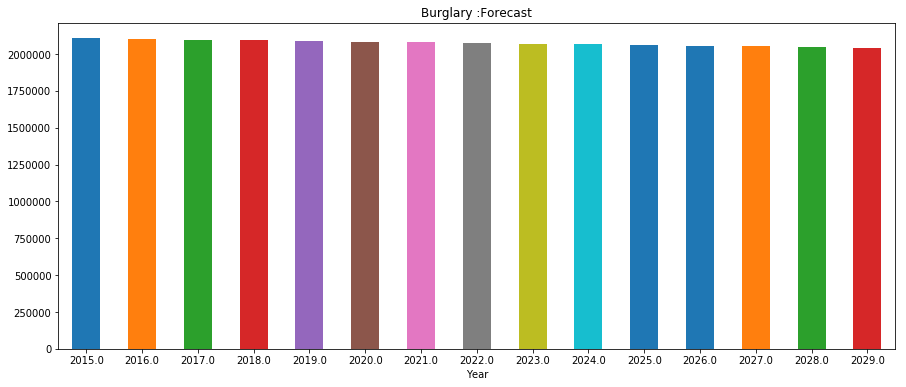

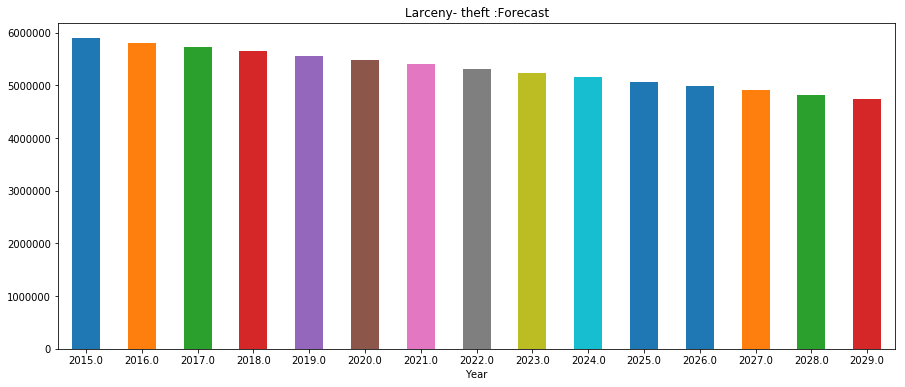

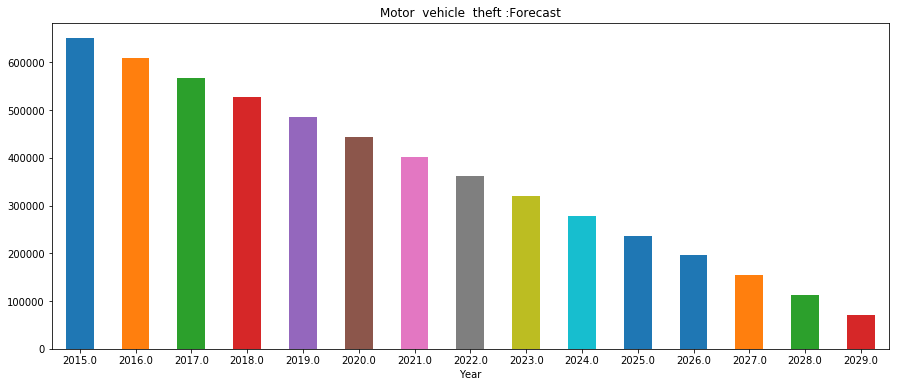

In [78]:
for k, v in plot_dict.items():
    fit_regression(eval(k), log_scale = False, forecast=True)

In [79]:
crime_data

,index,Year,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate,Rape (legacy definition)2,Rape (legacy definition)2 rate,Robbery,...,Aggravated assault,Aggravated assault rate,Property crime,Property crime rate,Burglary,Burglary rate,Larceny- theft,Larceny- theft rate,Motor vehicle theft,Motor vehicle theft rate
0,4,1998,270248003,1533887,567,16974,6,93144,34,447186,...,976583,361,10951827,4052,2332735,863,7376311,2729,1242781,459
1,5,1999,272690813,1426044,523,15522,5,89411,32,409371,...,911740,334,10208334,3743,2100739,770,6955520,2550,1152075,422
2,6,2000,281421906,1425486,506,15586,5,90178,32,408016,...,911706,324,10182584,3618,2050992,728,6971590,2477,1160002,412
3,7,2001,285317559,1439480,504,16037,5,90863,31,423557,...,909023,318,10437189,3658,2116531,741,7092267,2485,1228391,430
4,8,2002,287973924,1423677,494,16229,5,95235,33,420806,...,891407,309,10455277,3630,2151252,747,7057379,2450,1246646,432
5,9,2003,290788976,1383676,475,16528,5,93883,32,414235,...,859030,295,10442862,3591,2154834,741,7026802,2416,1261226,433
6,10,2004,293656842,1360088,463,16148,5,95089,32,401470,...,847381,288,10319386,3514,2144446,730,6937089,2362,1237851,421
7,11,2005,296507061,1390745,469,16740,5,94347,31,417438,...,862220,290,10174754,3431,2155448,726,6783447,2287,1235859,416
8,12,2006,299398484,1435123,479,17309,5,94472,31,449246,...,874096,292,10019601,3346,2194993,733,6626363,2213,1198245,400
9,13,2007,301621157,1422970,471,17128,5,92160,30,447324,...,866358,287,9882212,3276,2190198,726,6591542,2185,1100472,364


### Random Foreest Regression

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
def fit_random_forrest_regression(X):
    import matplotlib
    y1 = np.array(X)
    y1 = y1.astype(float).reshape(y1.size,1)
    x1 = np.asarray(X.index)
    x1 = x1.astype(float).reshape(x1.size,1)

    X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=0)
    # Feature Scaling

    sc = StandardScaler()  
#     X_train = sc.fit_transform(X_train)  
#     X_test = sc.transform(X_test)
    
#     y_train = sc.fit_transform(y_train)  
#     y_test = sc.transform(y_test)  

    regressor = RandomForestRegressor(n_estimators=500, random_state=0)  
    regressor.fit(X_train, y_train)  
    y_pred = regressor.predict(X_test)
    

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  
    print('')
    print(f'Predicted values: {y_pred}',f'Actual values: {y_test}')
    
    
    fig, ax = plt.subplots()

    ax.scatter(X_test, y_test, label='actual',
                edgecolors='none')
    ax.scatter(X_test, y_pred, label='predicted',
                edgecolors='none')
    ax.set_title(str(X.columns[0]))
    ax.legend()
    ax.grid(True)

    plt.show()
    
    
#     matplotlib.pyplot.scatter(X_test, y_test, marker='*')
#     matplotlib.pyplot.scatter(X_test, y_pred)
#     plt.plot(X_test, y_test)
#     plt.plot(X_test, y_pred)
#     plt.show()
    return 'Success!'

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 45049.418000000005
Mean Squared Error: 2256983235.130307
Root Mean Squared Error: 47507.71763756187

Predicted values: [1495342.628 1388821.916 1390544.65  1385383.222] Actual values: [[1426044.]
 [1360088.]
 [1435123.]
 [1422970.]]


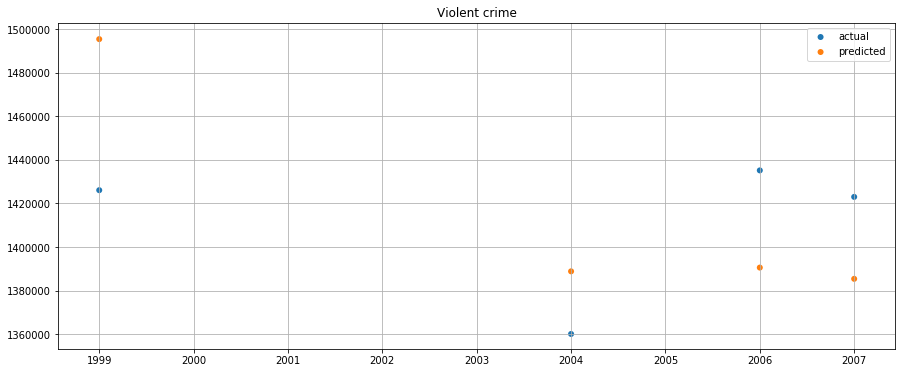

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 690.8395
Mean Squared Error: 523062.2579690001
Root Mean Squared Error: 723.2304321369504

Predicted values: [16524.876 16547.66  16649.112 16427.066] Actual values: [[15522.]
 [16148.]
 [17309.]
 [17128.]]


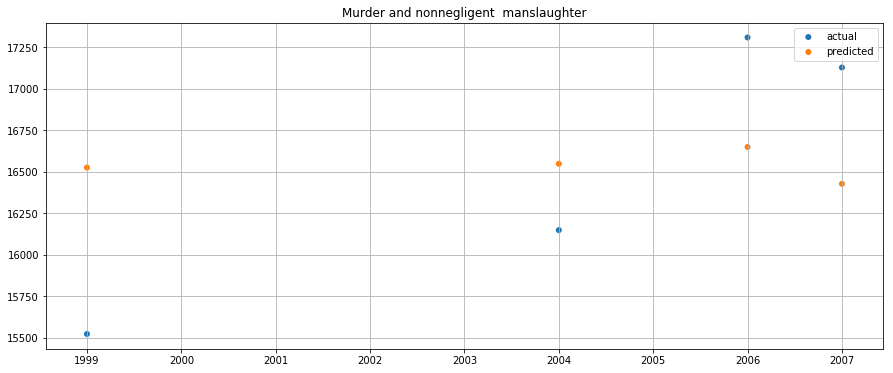

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 20171.037999999986
Mean Squared Error: 439277448.5257495
Root Mean Squared Error: 20958.946741803356

Predicted values: [434449.278 415508.54  422666.32  432336.346] Actual values: [[409371.]
 [401470.]
 [449246.]
 [447324.]]


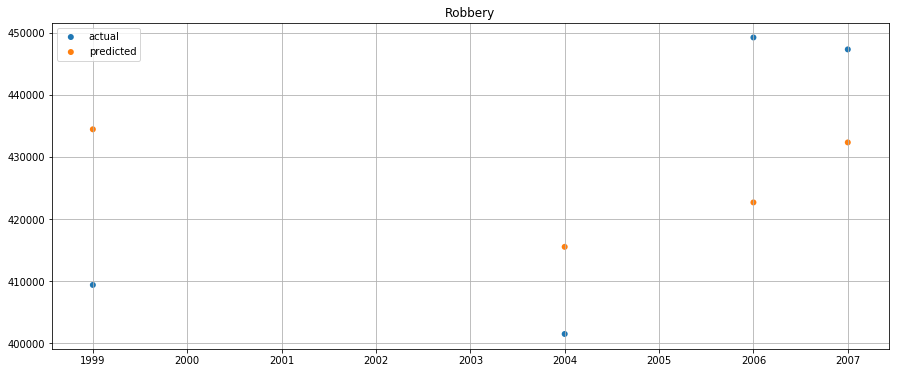

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 23344.631999999983
Mean Squared Error: 646676832.8843298
Root Mean Squared Error: 25429.841385355314

Predicted values: [952124.954 862764.904 857725.778 845118.552] Actual values: [[911740.]
 [847381.]
 [874096.]
 [866358.]]


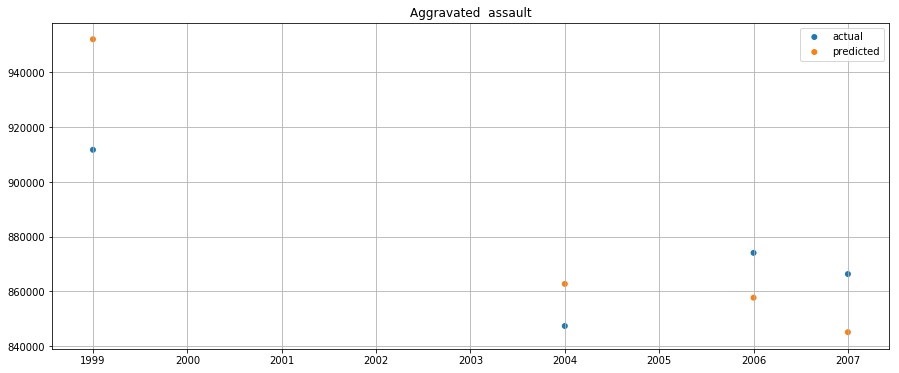

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 169353.4870000002
Mean Squared Error: 63113207793.889626
Root Mean Squared Error: 251223.42206468256

Predicted values: [10698120.07  10379701.572 10103508.782  9838807.476] Actual values: [[10208334.]
 [10319386.]
 [10019601.]
 [ 9882212.]]


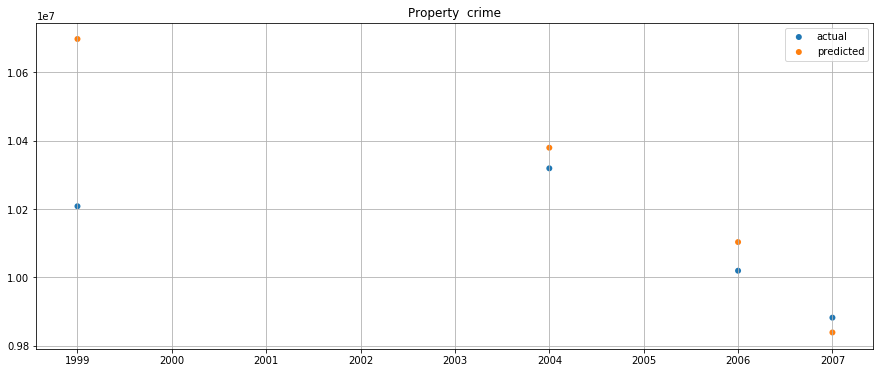

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 46472.145499999984
Mean Squared Error: 4947089843.261155
Root Mean Squared Error: 70335.55177334684

Predicted values: [2238231.792 2153665.098 2171423.878 2205805.57 ] Actual values: [[2100739.]
 [2144446.]
 [2194993.]
 [2190198.]]


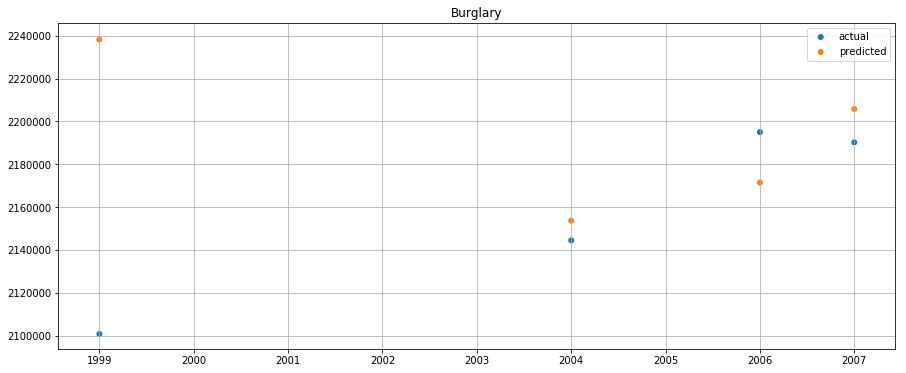

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 118459.21399999992
Mean Squared Error: 24932269819.492252
Root Mean Squared Error: 157899.5561092312

Predicted values: [7239744.574 6972587.918 6757316.96  6614701.404] Actual values: [[6955520.]
 [6937089.]
 [6626363.]
 [6591542.]]


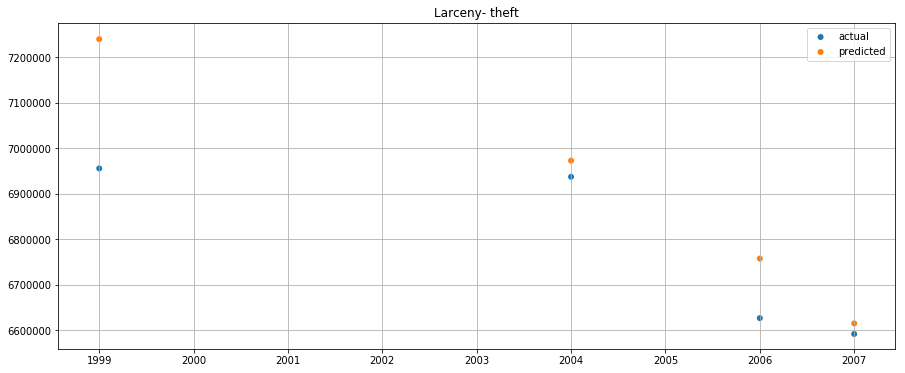

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 47328.70350000003
Mean Squared Error: 3044989864.8509727
Root Mean Squared Error: 55181.42681057615

Predicted values: [1220143.704 1253448.556 1174767.944 1018300.502] Actual values: [[1152075.]
 [1237851.]
 [1198245.]
 [1100472.]]


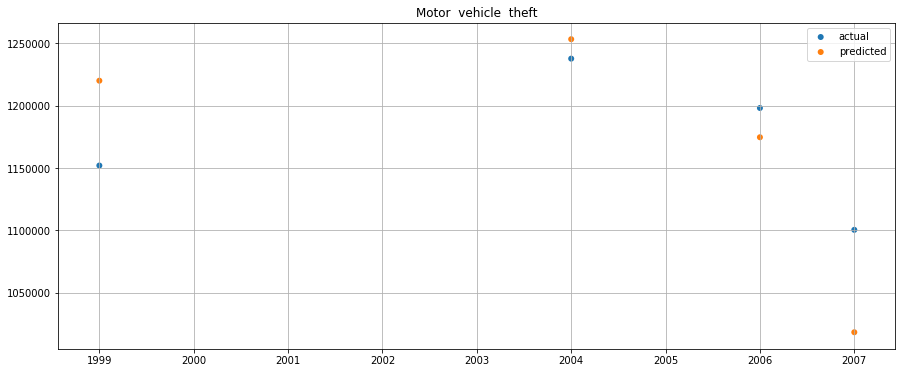

In [81]:
for k, v in plot_dict.items():
    fit_random_forrest_regression(eval(k))

In [82]:
# req_data = req_data.set_index('Year')
# Violent_crimes=req_data[['Violent crime']]
# Murder_and_manslaughter=req_data[['Murder and nonnegligent  manslaughter']]
# Robbery = req_data[['Robbery']]
# Aggravated_assault = req_data[['Aggravated  assault']]
# Property_crime = req_data[['Property  crime']]
# Burglary = req_data[['Burglary']]
# Larceny_theft = req_data[['Larceny- theft']]
# Motor_vehicle_theft = req_data[['Motor  vehicle  theft']]

## Running Forecast with Fbprophet
### Assuming each year trend starting with Jan-1st

### Violent_crimes Forecast

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


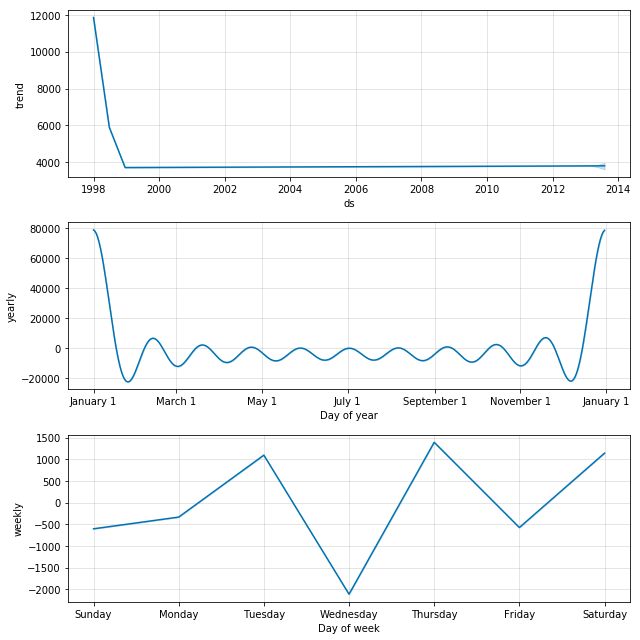

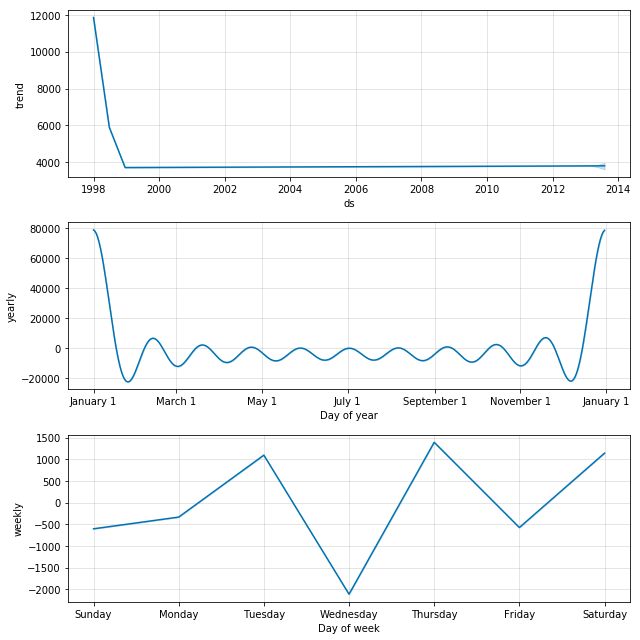

In [41]:
new_list = [(str(row)+'-01-01') for row in Violent_crimes.index]
# print(new_list)
Violent_crimes['new_datetime'] = new_list
# # qq = Violent_crimes[['new_datetime', 'Violent crime']]
# print(Violent_crimes)
Violent_crimes['new_datetime'] = pd.to_datetime(Violent_crimes.new_datetime,format='%Y-%m-%d') 
Violent_crimes.index = Violent_crimes.new_datetime
daily_train = Violent_crimes.resample('D').sum()
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train['Violent crime']
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(daily_train)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)
m.plot_components(forecast)

## Murder_and_manslaughter Forecast

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


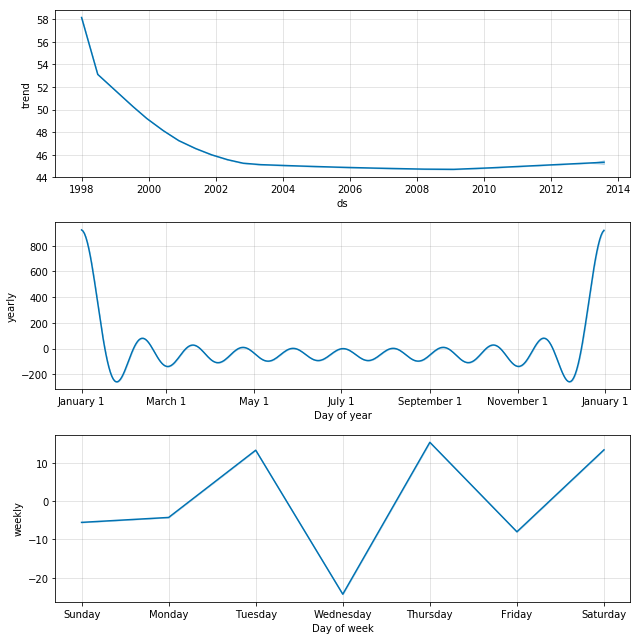

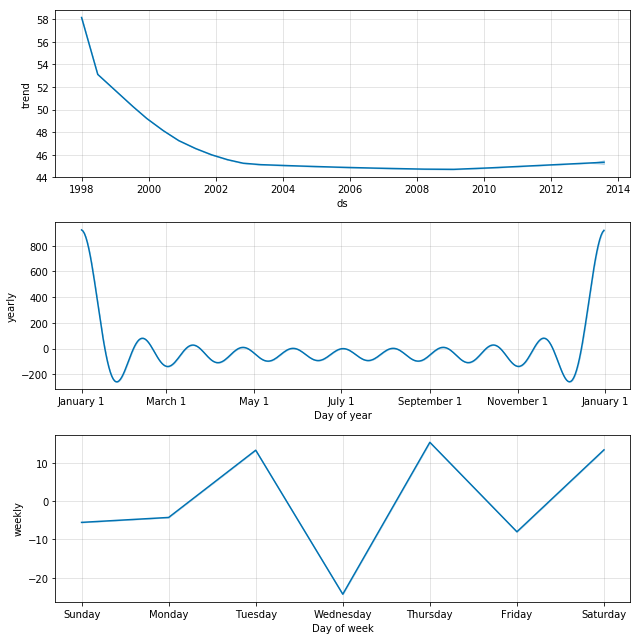

In [83]:
new_list = [(str(row)+'-01-01') for row in Murder_and_manslaughter.index]
# print(new_list)
Murder_and_manslaughter['new_datetime'] = new_list
# # qq = Violent_crimes[['new_datetime', 'Violent crime']]
# print(Violent_crimes)
Murder_and_manslaughter['new_datetime'] = pd.to_datetime(Murder_and_manslaughter.new_datetime,format='%Y-%m-%d') 
Murder_and_manslaughter.index = Murder_and_manslaughter.new_datetime
daily_train = Murder_and_manslaughter.resample('D').sum()
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train['Murder and nonnegligent  manslaughter']
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(daily_train)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)
m.plot_components(forecast)

### Robbery Forecast

/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vishnu/.virtualenvs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


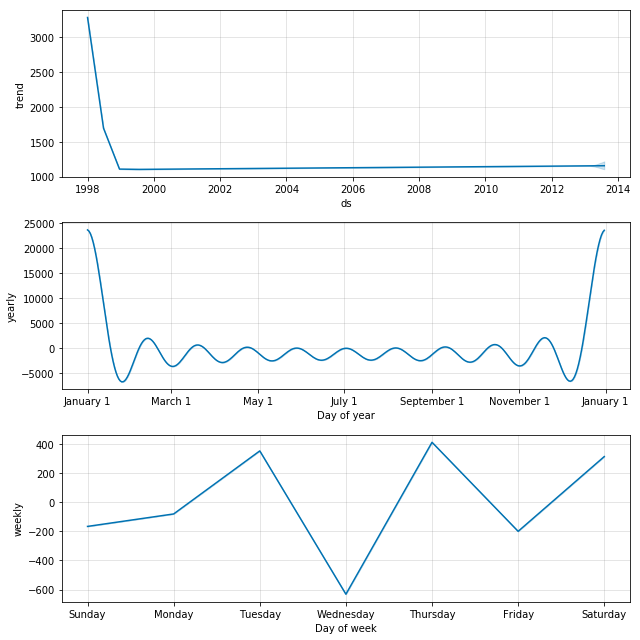

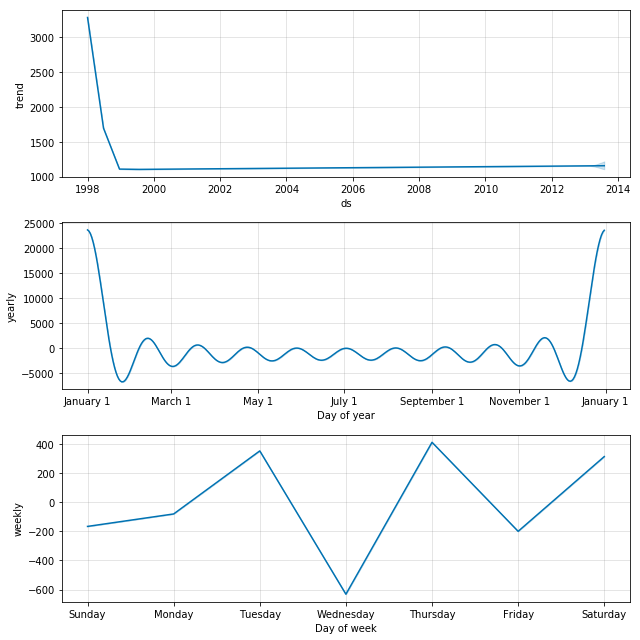

In [84]:
new_list = [(str(row)+'-01-01') for row in Robbery.index]
# print(new_list)
Robbery['new_datetime'] = new_list
# # qq = Violent_crimes[['new_datetime', 'Violent crime']]
# print(Violent_crimes)
Robbery['new_datetime'] = pd.to_datetime(Robbery.new_datetime,format='%Y-%m-%d') 
Robbery.index = Robbery.new_datetime
daily_train = Robbery.resample('D').sum()
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train['Robbery']
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(daily_train)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)
m.plot_components(forecast)